### Phonopy and CHGNet workflow custom 

In [1]:
from pymatgen.io.phonopy import get_displaced_structures, get_phonopy_structure, get_pmg_structure
from pymatgen.core import Structure 
import numpy as np 
import warnings
import tqdm 
warnings.simplefilter("ignore", DeprecationWarning)

In [4]:
struct = Structure.from_file('../CuAg/host/SPOSCAR').to_conventional()
struct

Structure Summary
Lattice
    abc : 3.6351088431226177 3.6351088431226177 3.6351088431226177
 angles : 90.0 90.0 90.0
 volume : 48.03438751019747
      A : np.float64(3.6351088431226177) np.float64(0.0) np.float64(2.225862204641176e-16)
      B : np.float64(-2.225862204641176e-16) np.float64(3.6351088431226177) np.float64(2.225862204641176e-16)
      C : np.float64(0.0) np.float64(0.0) np.float64(3.6351088431226177)
    pbc : True True True
PeriodicSite: Cu (0.0, 0.0, 0.0) [0.0, 0.0, 0.0]
PeriodicSite: Cu (-1.113e-16, 1.818, 1.818) [0.0, 0.5, 0.5]
PeriodicSite: Cu (1.818, 0.0, 1.818) [0.5, 0.0, 0.5]
PeriodicSite: Cu (1.818, 1.818, 2.226e-16) [0.5, 0.5, 0.0]

In [5]:
matrix = [2,2,2]

In [6]:
from chgnet.model.dynamics import StructOptimizer
from phonopy import Phonopy 

def get_phonons_workflow(structure,matrix,**displacement_kws):
    # 1. relax the primitive
    so = StructOptimizer(use_device='mps')
    relaxed = so.relax(struct,fmax=1e-4,verbose=False)
    final_structure = relaxed['final_structure']
    # 2. get the displaced structures 
    displacements = get_displaced_structures(final_structure,supercell_matrix=matrix)[1:] # first item is the original structure
    forces = []
    for d in displacements:
        oneshot = so.relax(d,steps=1,relax_cell=False,verbose=False)
        forces.append(oneshot['trajectory'].forces[-1])

    phonon = Phonopy(
        get_phonopy_structure(final_structure),
        supercell_matrix = matrix,
       # primitive_matrix = [[1,0,0],[0,1,0],[0,0,1]], #unsure about this
        #symprec=0.01,
        #is_symmetry=True,
    )    

    set_of_forces = [np.array(f) for f in forces]
    phonon.generate_displacements()
    phonon.produce_force_constants(forces=set_of_forces)
    return(phonon,final_structure)


In [10]:
conv_phonon,conv_struct = get_phonons_workflow(
    structure=struct,
    matrix=matrix
)

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py312/lib/python3.12/site-packages/matplotlib/pyplot.py'>

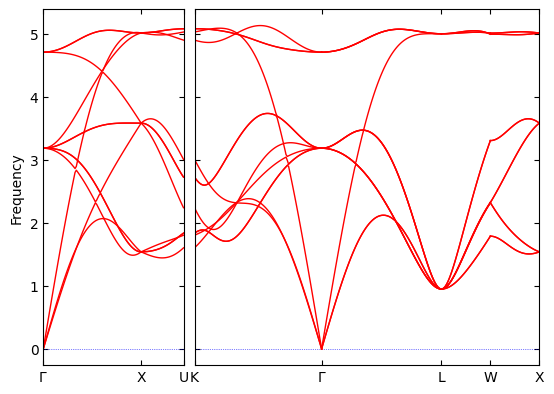

In [11]:
conv_phonon.auto_band_structure()
conv_phonon.plot_band_structure()

In [64]:
supercell = struct*matrix

# change some Cu's to Ag's 

for i in range(4):
    supercell.replace(idx=i,species='Ag')
so = StructOptimizer(use_device='mps')
relaxed = so.relax(supercell,fmax=1e-4,verbose=False)
relaxed_supercell = relaxed['final_structure']    

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


In [65]:
def get_supercell_phonons_workflow(structure,**displacement_kws): # this should be combined with the previous function 
    # 2. get the displaced structures 
    phonon = Phonopy(
        get_phonopy_structure(structure),
        supercell_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]]),
        #primitive_matrix = np.array([[1,0,0],[0,1,0],[0,0,1]]), #unsure about this
        symprec=1e-10,
        is_symmetry=False,
    )    
    phonon.generate_displacements()
    print(len(phonon.get_displacements()))
    displacements = [get_pmg_structure(phonopy_struct) for phonopy_struct in phonon.get_supercells_with_displacements()]

    forces = []

    so = StructOptimizer(use_device='mps')
    for d in tqdm.tqdm(displacements):
        oneshot = so.relax(d,steps=1,relax_cell=False,verbose=False)
        forces.append(oneshot['trajectory'].forces[-1])

    set_of_forces = [np.array(f) for f in forces]
    phonon.produce_force_constants(forces=set_of_forces)
    return(phonon)

In [66]:
sup_phon = get_supercell_phonons_workflow(relaxed_supercell)

192
CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on mps


100%|██████████| 192/192 [00:21<00:00,  9.03it/s]


<module 'matplotlib.pyplot' from '/Users/badw/miniconda3/envs/py312/lib/python3.12/site-packages/matplotlib/pyplot.py'>

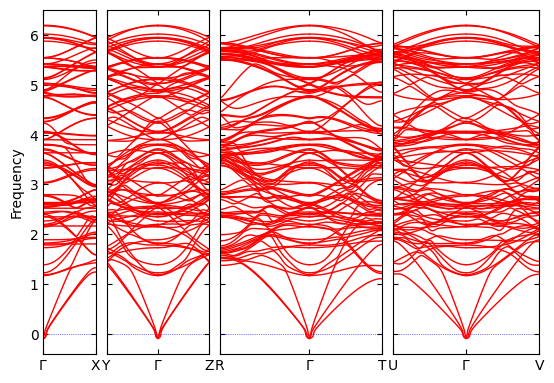

In [67]:
sup_phon.auto_band_structure()
sup_phon.plot_band_structure()

to use with `puppy` as a quick hack for now we need to save SPOSCARs and FORCE_SETS

In [68]:
from phonopy.file_IO import write_FORCE_SETS
import os 

def make_phonopy_files(directory,primitive_phonons,supercell_phonons):
    os.makedirs(directory+'primitive',exist_ok=True)
    os.makedirs(directory+'supercell',exist_ok=True)
    #write primitive files
    get_pmg_structure(primitive_phonons.supercell).to(directory+'primitive/'+'SPOSCAR',fmt='poscar')
    write_FORCE_SETS(primitive_phonons.dataset,directory+'primitive/'+'FORCE_SETS') 
    #write supercell files 
    get_pmg_structure(supercell_phonons.supercell).to(directory+'supercell/'+'SPOSCAR',fmt='poscar')
    write_FORCE_SETS(supercell_phonons.dataset,directory+'supercell/'+'FORCE_SETS') 

os.makedirs('./CuAg_chgnet',exist_ok=True)
make_phonopy_files(
    directory='./CuAg_chgnet/',
    primitive_phonons=conv_phonon,
    supercell_phonons=sup_phon
)

In [72]:
from puppy.unfolder import PhononUnfoldingandProjection as Puppy

puppy = Puppy(
    supercell_directory='./CuAg_chgnet/supercell/',
    host_directory='./CuAg_chgnet/primitive/',
    line_density=51,
    smatrix=[[2,0,0],[0,2,0],[0,0,2]],
)

In [73]:
_ = puppy.run_unfold()

Unfolding phonons...: 100%|██████████| 306/306 [00:01<00:00, 159.53it/s]


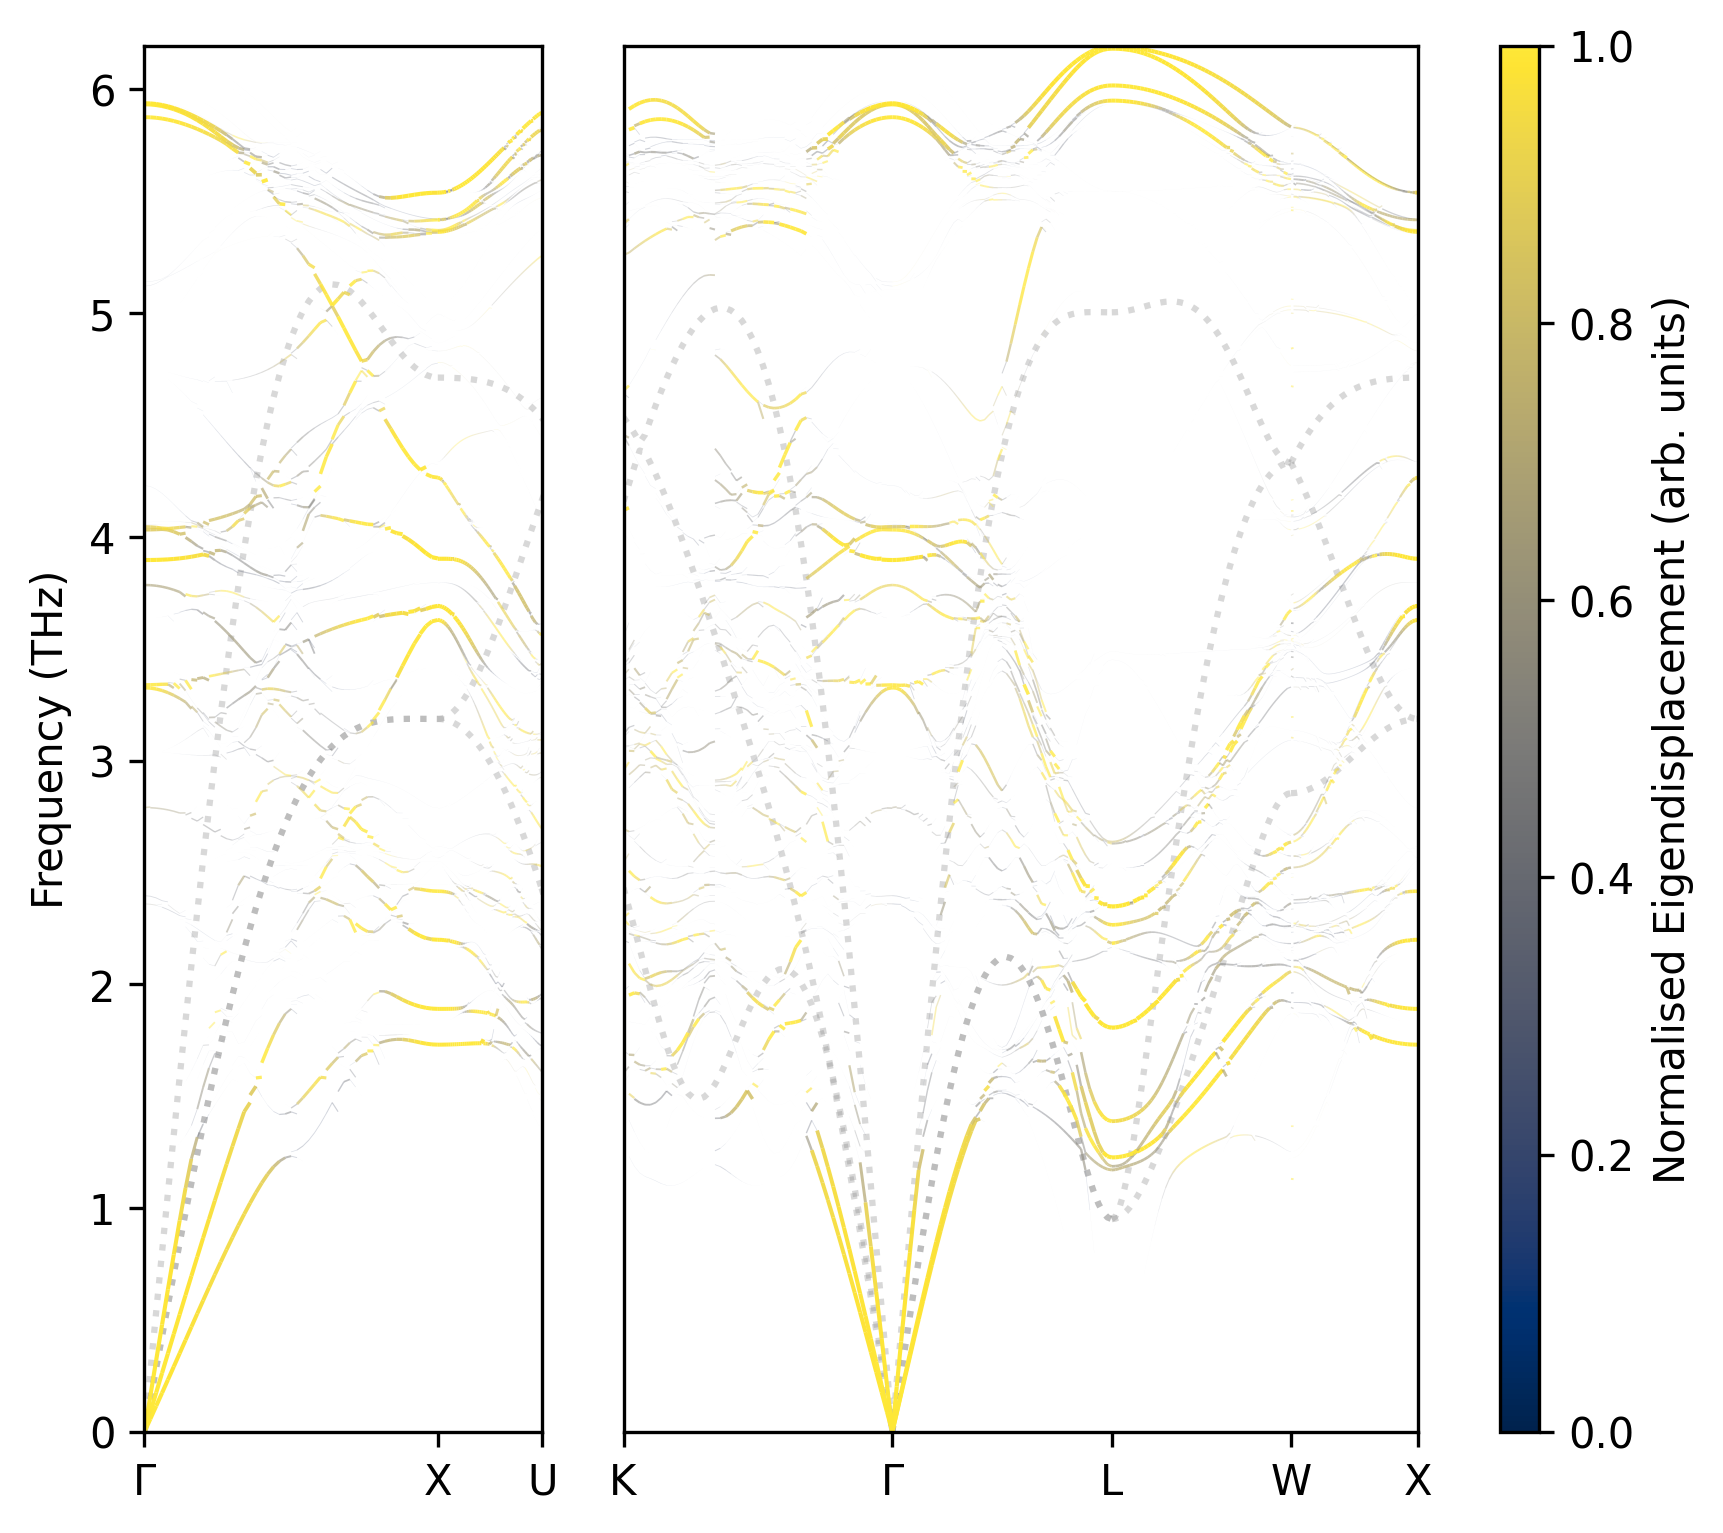

In [77]:
from puppy.plotting import PuppyPlotter

pp =PuppyPlotter(puppy)
fig,axes = pp.plot(plot_primitive=True)